# Before Pruning

## Mistral 7B

In [2]:
import torch
from transformers import MistralForCausalLM, AutoTokenizer

directory = "../model/mistral_7b_v01__MistralAI"
model = MistralForCausalLM.from_pretrained(directory, device_map="auto")
model

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

In [3]:
import time
from tqdm import tqdm
import torch
from transformers import MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import math

directory = "../model/mistral_7b_v01__MistralAI"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = MistralForCausalLM.from_pretrained(directory, device_map="auto")

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

# perplexity 계산: STRIDE = 32
lls = []
total_steps = len(split_input_ids)
passed_samples = 0
total_samples = 0

# 시간 측정 시작
start_time = time.time()
for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
    total_samples += 1

    if chunk.size(0) > max_sample_length:
        passed_samples += 1
        print(f"Skipping large sample at chunk {i}")
        continue

    for j in range(0, chunk.size(0), stride):
        begin_loc = max(j + stride - max_length, 0)
        end_loc = min(j + stride, chunk.size(0))
        trg_len = end_loc - j

        input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
        target_ids = input_ids_chunk.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids_chunk)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = target_ids[:, 1:].contiguous()
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            log_likelihood = loss * trg_len

        lls.append(log_likelihood.cpu())

ppl = torch.exp(torch.stack(lls).sum() / sum(len(chunk) for chunk in split_input_ids))
print(f"Perplexity: {ppl.item()}")

# 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 패스된 샘플 수와 전체 샘플 수 출력
print(f"Total samples processed: {total_samples}")
print(f"Samples passed: {passed_samples}")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Processing: 100%|██████████| 17/17 [31:13<00:00, 110.19s/it]

Perplexity: 5.520888805389404
Elapsed time: 1873.210417509079 seconds
Total samples processed: 17
Samples passed: 0


In [1]:
import time
from tqdm import tqdm
import torch
from transformers import MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import math

directory = "../model/mistral_7b_v01__MistralAI"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = MistralForCausalLM.from_pretrained(directory, device_map="auto")

# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test")  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

# perplexity 계산: STRIDE = 32
lls = []
total_steps = len(split_input_ids)
passed_samples = 0
total_samples = 0

# 시간 측정 시작
start_time = time.time()
for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
    total_samples += 1

    if chunk.size(0) > max_sample_length:
        passed_samples += 1
        print(f"Skipping large sample at chunk {i}")
        continue

    for j in range(0, chunk.size(0), stride):
        begin_loc = max(j + stride - max_length, 0)
        end_loc = min(j + stride, chunk.size(0))
        trg_len = end_loc - j

        input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
        target_ids = input_ids_chunk.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids_chunk)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = target_ids[:, 1:].contiguous()
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            log_likelihood = loss * trg_len

        lls.append(log_likelihood.cpu())

ppl = torch.exp(torch.stack(lls).sum() / sum(len(chunk) for chunk in split_input_ids))
print(f"Perplexity: {ppl.item()}")

# 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 패스된 샘플 수와 전체 샘플 수 출력
print(f"Total samples processed: {total_samples}")
print(f"Samples passed: {passed_samples}")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for ptb_text_only contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ptb_text_only
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Processing: 100%|██████████| 107/107 [53:05<00:00, 29.77s/it]

Perplexity: 27.74935531616211
Elapsed time: 3185.6439678668976 seconds
Total samples processed: 107
Samples passed: 0


In [1]:
import time
from tqdm import tqdm
import torch
from transformers import MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import math

directory = "../model/mistral_7b_v01__MistralAI"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = MistralForCausalLM.from_pretrained(directory, device_map="auto")

# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test[:20%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

# perplexity 계산: STRIDE = 32
lls = []
total_steps = len(split_input_ids)
passed_samples = 0
total_samples = 0
total_length = 0

# 시간 측정 시작
start_time = time.time()
for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
    total_samples += 1

    if chunk.size(0) > max_sample_length:
        passed_samples += 1
        print(f"Skipping large sample at chunk {i}")
        continue

    for j in range(0, chunk.size(0), stride):
        begin_loc = max(j + stride - max_length, 0)
        end_loc = min(j + stride, chunk.size(0))
        trg_len = end_loc - j
        total_length += trg_len

        input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
        target_ids = input_ids_chunk.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids_chunk)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = target_ids[:, 1:].contiguous()
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            log_likelihood = loss * trg_len

        lls.append(log_likelihood.cpu())

# 전체 로그 가능도의 합을 전체 토큰 수로 나누어 평균을 구함
average_log_likelihood = torch.stack(lls).sum() / total_length
ppl = torch.exp(average_log_likelihood)
print(f"Perplexity: {ppl.item()}")

# 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 패스된 샘플 수와 전체 샘플 수 출력
print(f"Total samples processed: {total_samples}")
print(f"Samples passed: {passed_samples}")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Processing: 100%|██████████| 23/23 [10:54<00:00, 28.47s/it]

Perplexity: 20.437850952148438
Elapsed time: 654.7533278465271 seconds
Total samples processed: 23
Samples passed: 0


## Llama-2 7B

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

directory = "../model/llama_2_7b_hf__meta_llama"
model = AutoModelForCausalLM.from_pretrained(directory, device_map="auto")
model

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [1]:
import time
from tqdm import tqdm
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import math

directory = "../model/llama_2_7b_hf__meta_llama"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = AutoModelForCausalLM.from_pretrained(directory, device_map="auto")

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

# perplexity 계산: STRIDE = 32
lls = []
total_steps = len(split_input_ids)
passed_samples = 0
total_samples = 0

# 시간 측정 시작
start_time = time.time()
for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
    total_samples += 1

    if chunk.size(0) > max_sample_length:
        passed_samples += 1
        print(f"Skipping large sample at chunk {i}")
        continue

    for j in range(0, chunk.size(0), stride):
        begin_loc = max(j + stride - max_length, 0)
        end_loc = min(j + stride, chunk.size(0))
        trg_len = end_loc - j

        input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
        target_ids = input_ids_chunk.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids_chunk)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = target_ids[:, 1:].contiguous()
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            log_likelihood = loss * trg_len

        lls.append(log_likelihood.cpu())

ppl = torch.exp(torch.stack(lls).sum() / sum(len(chunk) for chunk in split_input_ids))
print(f"Perplexity: {ppl.item()}")

# 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 패스된 샘플 수와 전체 샘플 수 출력
print(f"Total samples processed: {total_samples}")
print(f"Samples passed: {passed_samples}")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Processing: 100%|██████████| 17/17 [07:49<00:00, 27.59s/it]

Perplexity: 5.761183738708496
Elapsed time: 469.0346462726593 seconds
Total samples processed: 17
Samples passed: 0


In [1]:
import time
from tqdm import tqdm
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import math

directory = "../model/llama_2_7b_hf__meta_llama"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = AutoModelForCausalLM.from_pretrained(directory, device_map="auto")

dataset = load_dataset("c4", "en", split="train[:20%]")  # 데이터셋의 5%만 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

# perplexity 계산: STRIDE = 32
lls = []
total_steps = len(split_input_ids)
passed_samples = 0
total_samples = 0

# 시간 측정 시작
start_time = time.time()
for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
    total_samples += 1

    if chunk.size(0) > max_sample_length:
        passed_samples += 1
        print(f"Skipping large sample at chunk {i}")
        continue

    for j in range(0, chunk.size(0), stride):
        begin_loc = max(j + stride - max_length, 0)
        end_loc = min(j + stride, chunk.size(0))
        trg_len = end_loc - j

        input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
        target_ids = input_ids_chunk.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids_chunk)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = target_ids[:, 1:].contiguous()
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            log_likelihood = loss * trg_len

        lls.append(log_likelihood.cpu())

ppl = torch.exp(torch.stack(lls).sum() / sum(len(chunk) for chunk in split_input_ids))
print(f"Perplexity: {ppl.item()}")

# 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 패스된 샘플 수와 전체 샘플 수 출력
print(f"Total samples processed: {total_samples}")
print(f"Samples passed: {passed_samples}")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Processing: 100%|██████████| 17/17 [07:49<00:00, 27.59s/it]

Perplexity: 5.761183738708496
Elapsed time: 469.0346462726593 seconds
Total samples processed: 17
Samples passed: 0


In [1]:
import time
from tqdm import tqdm
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import math

directory = "../model/llama_2_7b_hf__meta_llama"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = AutoModelForCausalLM.from_pretrained(directory, device_map="auto")

# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test[:20%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

# perplexity 계산: STRIDE = 32
lls = []
total_steps = len(split_input_ids)
passed_samples = 0
total_samples = 0
total_length = 0

# 시간 측정 시작
start_time = time.time()
for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
    total_samples += 1

    if chunk.size(0) > max_sample_length:
        passed_samples += 1
        print(f"Skipping large sample at chunk {i}")
        continue

    for j in range(0, chunk.size(0), stride):
        begin_loc = max(j + stride - max_length, 0)
        end_loc = min(j + stride, chunk.size(0))
        trg_len = end_loc - j
        total_length += trg_len

        input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
        target_ids = input_ids_chunk.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids_chunk)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = target_ids[:, 1:].contiguous()
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            log_likelihood = loss * trg_len

        lls.append(log_likelihood.cpu())

# 전체 로그 가능도의 합을 전체 토큰 수로 나누어 평균을 구함
average_log_likelihood = torch.stack(lls).sum() / total_length
ppl = torch.exp(average_log_likelihood)
print(f"Perplexity: {ppl.item()}")

# 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 패스된 샘플 수와 전체 샘플 수 출력
print(f"Total samples processed: {total_samples}")
print(f"Samples passed: {passed_samples}")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Processing: 100%|██████████| 24/24 [10:48<00:00, 27.00s/it]

Perplexity: 19.79205894470215
Elapsed time: 648.0248844623566 seconds
Total samples processed: 24
Samples passed: 0


# Random

## Mistral

In [1]:
import torch
import random
from transformers import MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class RandomPrunedModel(MistralForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.pruned_layers = set()
    
    def prune_layers(self, num_layers_to_prune):
        total_layers = len(self.model.layers)
        self.pruned_layers = set(random.sample(range(total_layers), num_layers_to_prune))

    def forward(self, input_ids, **kwargs):
        hidden_states = self.model.embed_tokens(input_ids)
        
        for i, layer_module in enumerate(self.model.layers):
            if i in self.pruned_layers:
                continue

            hidden_states = layer_module(hidden_states, **kwargs)[0]

        hidden_states = self.model.norm(hidden_states)
        logits = self.lm_head(hidden_states)
        return logits
# 모델 로드
directory = "../model/mistral_7b_v01__MistralAI"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = RandomPrunedModel.from_pretrained(directory, device_map="auto")


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test[:15%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)


In [3]:
def calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride):
    lls = []
    total_steps = len(split_input_ids)
    passed_samples = 0
    total_samples = 0
    total_length = 0
    start_time = time.time()
    
    for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
        total_samples += 1

        if chunk.size(0) > max_sample_length:
            passed_samples += 1
            continue

        for j in range(0, chunk.size(0), stride):
            begin_loc = max(j + stride - max_length, 0)
            end_loc = min(j + stride, chunk.size(0))
            trg_len = end_loc - j
            total_length += trg_len

            input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
            target_ids = input_ids_chunk.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids_chunk)
                # print(outputs)
                # print(outputs.shape)
                shift_logits = outputs[:, :-1, :].contiguous()
                shift_labels = target_ids[:, 1:].contiguous()
                loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                log_likelihood = loss * trg_len

            lls.append(log_likelihood.cpu())
    
    average_log_likelihood = torch.stack(lls).sum() / total_length
    ppl = torch.exp(average_log_likelihood)
    end_time = time.time()
    latency = end_time - start_time
    
    return ppl.item(), latency


In [4]:
results = []

for num_pruned_layers in range(1, 6):  # 0에서 5까지
    model.prune_layers(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()


Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:41<00:00, 27.18s/it]


Perplexity: 21.284154891967773, Latency: 462.0262870788574 seconds
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:32<00:00, 26.64s/it]


Perplexity: 23.04996681213379, Latency: 452.922082901001 seconds
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:20<00:00, 25.88s/it]


Perplexity: 34.24939727783203, Latency: 440.00926423072815 seconds
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [07:09<00:00, 25.25s/it]


Perplexity: 41.47211837768555, Latency: 429.31597995758057 seconds
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:52<00:00, 24.26s/it]

Perplexity: 37.67332458496094, Latency: 412.3584249019623 seconds


In [10]:
results

[(1, 0.03125, 21.284154891967773, 462.0262870788574),
 (2, 0.0625, 23.04996681213379, 452.922082901001),
 (3, 0.09375, 34.24939727783203, 440.00926423072815),
 (4, 0.125, 41.47211837768555, 429.31597995758057),
 (5, 0.15625, 37.67332458496094, 412.3584249019623)]

In [19]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)


In [20]:
results_ = []

for num_pruned_layers in range(1, 6):  # 0에서 5까지
    model.prune_layers(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()


Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:53<00:00, 27.85s/it]


Perplexity: 6.015398025512695, Latency: 473.50696063041687 seconds
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:45<00:00, 27.36s/it]


Perplexity: 7.062404632568359, Latency: 465.1228108406067 seconds
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:31<00:00, 26.56s/it]


Perplexity: 10.950662612915039, Latency: 451.51061606407166 seconds
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [07:16<00:00, 25.70s/it]


Perplexity: 6787.62841796875, Latency: 436.8935739994049 seconds
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:56<00:00, 24.49s/it]

Perplexity: 12.865921974182129, Latency: 416.32886576652527 seconds


In [22]:
results_

[(1, 0.03125, 6.015398025512695, 473.50696063041687),
 (2, 0.0625, 7.062404632568359, 465.1228108406067),
 (3, 0.09375, 10.950662612915039, 451.51061606407166),
 (4, 0.125, 6787.62841796875, 436.8935739994049),
 (5, 0.15625, 12.865921974182129, 416.32886576652527)]

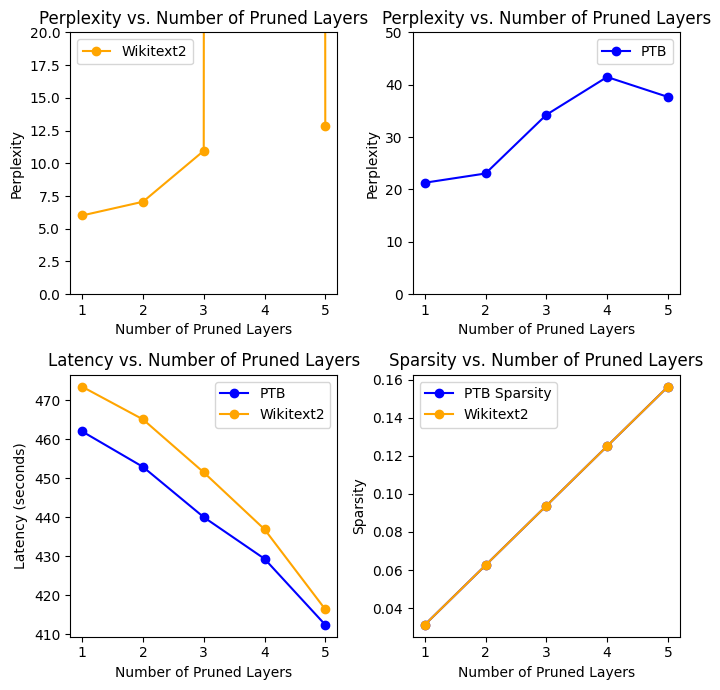

In [35]:
# PTB 데이터셋 결과
num_pruned_layers_ptb = [r[0] for r in results]
sparsities_ptb = [r[1] for r in results]
ppls_ptb = [r[2] for r in results]
latencies_ptb = [r[3] for r in results]

# Wikitext2 데이터셋 결과
num_pruned_layers_wikitext = [r[0] for r in results_]
sparsities_wikitext = [r[1] for r in results_]
ppls_wikitext = [r[2] for r in results_]
latencies_wikitext = [r[3] for r in results_]

plt.figure(figsize=(7, 7))

# Perplexity
plt.subplot(2, 2, 1)
plt.plot(num_pruned_layers_wikitext, ppls_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Perplexity")
plt.ylim(0, 20)
plt.title("Perplexity vs. Number of Pruned Layers")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(num_pruned_layers_ptb, ppls_ptb, marker='o', label="PTB", color='b')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Perplexity")
plt.ylim(0, 50)
plt.title("Perplexity vs. Number of Pruned Layers")
plt.legend()

# Latency
plt.subplot(2, 2, 3)
plt.plot(num_pruned_layers_ptb, latencies_ptb, marker='o', label="PTB", color='b')
plt.plot(num_pruned_layers_wikitext, latencies_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. Number of Pruned Layers")
plt.legend()

# Sparsity
plt.subplot(2, 2, 4)
plt.plot(num_pruned_layers_ptb, sparsities_ptb, marker='o', label="PTB Sparsity", color='b')
plt.plot(num_pruned_layers_wikitext, sparsities_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Sparsity")
plt.title("Sparsity vs. Number of Pruned Layers")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 몇 번째 레이어가 prune됐는지 index를 표시

## Llama-2

In [1]:
import torch
import random
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class RandomPrunedModel(AutoModelForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.pruned_layers = set()
    
    def prune_layers(self, num_layers_to_prune):
        total_layers = len(self.model.layers)
        self.pruned_layers = set(random.sample(range(total_layers), num_layers_to_prune))

    def forward(self, input_ids, **kwargs):
        hidden_states = self.model.embed_tokens(input_ids)
        
        for i, layer_module in enumerate(self.model.layers):
            if i in self.pruned_layers:
                continue

            hidden_states = layer_module(hidden_states, **kwargs)[0]

        hidden_states = self.model.norm(hidden_states)
        logits = self.lm_head(hidden_states)
        return logits
# 모델 로드
directory = "../model/llama_2_7b_hf__meta_llama"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = RandomPrunedModel.from_pretrained(directory, device_map="auto")


You are using a model of type llama to instantiate a model of type mistral. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test[:15%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)


In [3]:
def calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride):
    lls = []
    total_steps = len(split_input_ids)
    passed_samples = 0
    total_samples = 0
    total_length = 0
    start_time = time.time()
    
    for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
        total_samples += 1

        if chunk.size(0) > max_sample_length:
            passed_samples += 1
            continue

        for j in range(0, chunk.size(0), stride):
            begin_loc = max(j + stride - max_length, 0)
            end_loc = min(j + stride, chunk.size(0))
            trg_len = end_loc - j
            total_length += trg_len

            input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
            target_ids = input_ids_chunk.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids_chunk)
                # print(outputs)
                # print(outputs.shape)
                shift_logits = outputs[:, :-1, :].contiguous()
                shift_labels = target_ids[:, 1:].contiguous()
                loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                log_likelihood = loss * trg_len

            lls.append(log_likelihood.cpu())
    
    average_log_likelihood = torch.stack(lls).sum() / total_length
    ppl = torch.exp(average_log_likelihood)
    end_time = time.time()
    latency = end_time - start_time
    
    return ppl.item(), latency


In [4]:
results_lp = []

for num_pruned_layers in range(1, 6):  # 0에서 5까지
    model.prune_layers(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_lp.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()


Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:30<00:00, 26.49s/it]


Perplexity: 20.941349029541016, Latency: 450.2723731994629 seconds
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:25<00:00, 26.22s/it]


Perplexity: 24.049449920654297, Latency: 445.71300625801086 seconds
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:13<00:00, 25.49s/it]


Perplexity: 26.312870025634766, Latency: 433.33492946624756 seconds
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [06:53<00:00, 24.32s/it]


Perplexity: 26.687814712524414, Latency: 413.4717321395874 seconds
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:46<00:00, 23.93s/it]

Perplexity: 88.3045425415039, Latency: 406.77405166625977 seconds


In [6]:
results_lp

[(1, 0.03125, 20.941349029541016, 450.2723731994629),
 (2, 0.0625, 24.049449920654297, 445.71300625801086),
 (3, 0.09375, 26.312870025634766, 433.33492946624756),
 (4, 0.125, 26.687814712524414, 413.4717321395874),
 (5, 0.15625, 88.3045425415039, 406.77405166625977)]

In [7]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)


In [8]:
results_lw = []

for num_pruned_layers in range(1, 6):  # 0에서 5까지
    model.prune_layers(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_lw.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()


Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:34<00:00, 26.71s/it]


Perplexity: 6.408919334411621, Latency: 454.1139419078827 seconds
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:18<00:00, 25.80s/it]


Perplexity: 6.699614524841309, Latency: 438.602162361145 seconds
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:05<00:00, 25.02s/it]


Perplexity: 8.182764053344727, Latency: 425.3496558666229 seconds
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [06:45<00:00, 23.88s/it]


Perplexity: 8.465189933776855, Latency: 405.9547872543335 seconds
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:35<00:00, 23.25s/it]

Perplexity: 9.312217712402344, Latency: 395.2152523994446 seconds


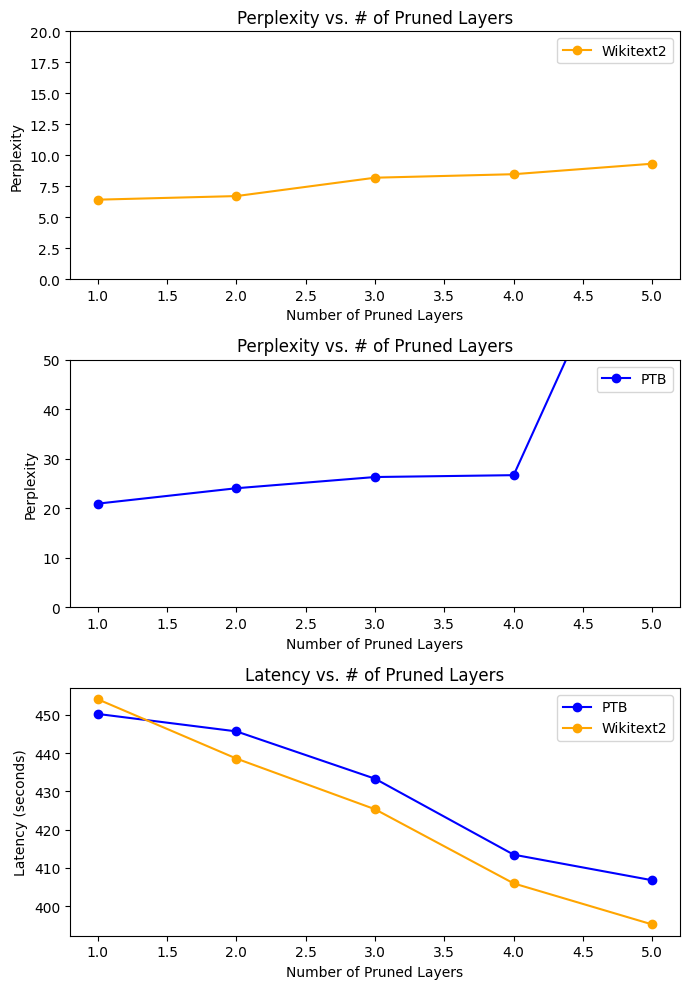

In [11]:
# PTB 데이터셋 결과
num_pruned_layers_ptb = [r[0] for r in results_lp]
sparsities_ptb = [r[1] for r in results_lp]
ppls_ptb = [r[2] for r in results_lp]
latencies_ptb = [r[3] for r in results_lp]

# Wikitext2 데이터셋 결과
num_pruned_layers_wikitext = [r[0] for r in results_lw]
sparsities_wikitext = [r[1] for r in results_lw]
ppls_wikitext = [r[2] for r in results_lw]
latencies_wikitext = [r[3] for r in results_lw]

plt.figure(figsize=(7, 10))

# Perplexity
plt.subplot(3, 1, 1)
plt.plot(num_pruned_layers_wikitext, ppls_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Perplexity")
plt.ylim(0, 20)
plt.title("Perplexity vs. # of Pruned Layers")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(num_pruned_layers_ptb, ppls_ptb, marker='o', label="PTB", color='b')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Perplexity")
plt.ylim(0, 50)
plt.title("Perplexity vs. # of Pruned Layers")
plt.legend()

# Latency
plt.subplot(3, 1, 3)
plt.plot(num_pruned_layers_ptb, latencies_ptb, marker='o', label="PTB", color='b')
plt.plot(num_pruned_layers_wikitext, latencies_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. # of Pruned Layers")
plt.legend()


plt.tight_layout()
plt.show()

# Entropy-based

## Mistral

In [1]:
import torch
import random
import torch.nn.functional as F
from transformers import MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class EntropyPrunedModel(MistralForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.pruned_layers = set()
        self.entropies = []

    def calculate_entropies(self, input_ids):
        self.entropies = []
        hidden_states = self.model.embed_tokens(input_ids)
        
        with torch.no_grad():
            for layer_module in self.model.layers:
                hidden_states = layer_module(hidden_states)[0]
                logits = self.lm_head(hidden_states[:, -1, :])
                probs = F.softmax(logits, dim=-1)
                top_probs, _ = torch.topk(probs, 10)
                entropy = -torch.sum(top_probs * torch.log(top_probs)).item()
                self.entropies.append(entropy)
    
    def prune_layers_by_entropy_diff(self, num_layers_to_prune):
        if not self.entropies:
            raise ValueError("Entropies not calculated. Please run entropy calculation before pruning.")
        print(np.ndim(self.entropies))
        print(len(self.entropies))
        # print(len(self.entropies[0]))
        entropy_diffs = []
        for i in range(1, len(self.entropies)):
            entropy_diff = self.entropies[i - 1] - self.entropies[i]
            entropy_diffs.append((i, entropy_diff))
        
        # Sort entropy differences in ascending order
        sorted_entropy_diffs = sorted(entropy_diffs, key=lambda x: x[1], reverse=False)
        
        # Select layers with largest entropy difference
        pruned_layers = []
        for i in range(num_layers_to_prune):
            layer_index, entropy_diff = sorted_entropy_diffs[i]
            pruned_layers.append(layer_index)
            print(f"Layer {layer_index}: Entropy Difference = {entropy_diff}")
        
        self.pruned_layers = set(pruned_layers)


    def forward(self, input_ids, **kwargs):
        hidden_states = self.model.embed_tokens(input_ids)
        
        for i, layer_module in enumerate(self.model.layers):
            if i in self.pruned_layers:
                continue
            hidden_states = layer_module(hidden_states, **kwargs)[0]
            
        hidden_states = self.model.norm(hidden_states)
        logits = self.lm_head(hidden_states)
        
        return logits

# 모델 로드
directory = "../model/mistral_7b_v01__MistralAI"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = EntropyPrunedModel.from_pretrained(directory, device_map="auto")

# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test[:15%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

def calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride):
    lls = []
    total_steps = len(split_input_ids)
    passed_samples = 0
    total_samples = 0
    total_length = 0
    start_time = time.time()
    
    for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
        total_samples += 1

        if chunk.size(0) > max_sample_length:
            passed_samples += 1
            continue

        for j in range(0, chunk.size(0), stride):
            begin_loc = max(j + stride - max_length, 0)
            end_loc = min(j + stride, chunk.size(0))
            trg_len = end_loc - j
            total_length += trg_len

            input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
            target_ids = input_ids_chunk.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids_chunk)
                shift_logits = outputs[:, :-1, :].contiguous()
                shift_labels = target_ids[:, 1:].contiguous()
                loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                log_likelihood = loss * trg_len

            lls.append(log_likelihood.cpu())
    
    average_log_likelihood = torch.stack(lls).sum() / total_length
    ppl = torch.exp(average_log_likelihood)
    end_time = time.time()
    latency = end_time - start_time
    
    return ppl.item(), latency

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
results_emp = []

# 초기 엔트로피 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_entropies(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_entropy_diff(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_emp.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()

1
32
Layer 31: Entropy Difference = -0.007350441068410873
Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:39<00:00, 27.04s/it]


Perplexity: 28.084095001220703, Latency: 459.6184628009796 seconds
1
32
Layer 31: Entropy Difference = -0.007350441068410873
Layer 30: Entropy Difference = -0.003433710429817438
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:30<00:00, 26.52s/it]


Perplexity: 60.770809173583984, Latency: 450.7812786102295 seconds
1
32
Layer 31: Entropy Difference = -0.007350441068410873
Layer 30: Entropy Difference = -0.003433710429817438
Layer 29: Entropy Difference = -0.0013187737204134464
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:17<00:00, 25.74s/it]


Perplexity: 135.5338134765625, Latency: 437.61810064315796 seconds
1
32
Layer 31: Entropy Difference = -0.007350441068410873
Layer 30: Entropy Difference = -0.003433710429817438
Layer 29: Entropy Difference = -0.0013187737204134464
Layer 28: Entropy Difference = -0.0007795109413564205
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [07:03<00:00, 24.92s/it]


Perplexity: 238.9453582763672, Latency: 423.72305727005005 seconds
1
32
Layer 31: Entropy Difference = -0.007350441068410873
Layer 30: Entropy Difference = -0.003433710429817438
Layer 29: Entropy Difference = -0.0013187737204134464
Layer 28: Entropy Difference = -0.0007795109413564205
Layer 27: Entropy Difference = -0.00036856113001704216
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:49<00:00, 24.10s/it]

Perplexity: 387.9535217285156, Latency: 409.7166986465454 seconds


In [3]:
results_emp

[(1, 0.03125, 28.084095001220703, 459.6184628009796),
 (2, 0.0625, 60.770809173583984, 450.7812786102295),
 (3, 0.09375, 135.5338134765625, 437.61810064315796),
 (4, 0.125, 238.9453582763672, 423.72305727005005),
 (5, 0.15625, 387.9535217285156, 409.7166986465454)]

In [4]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

split_input_ids = split_long_text(input_ids, max_sample_length)

In [5]:
results_emw = []

# 초기 엔트로피 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_entropies(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_entropy_diff(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_emw.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()

1
32
Layer 30: Entropy Difference = -0.001695806160569191
Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:50<00:00, 27.65s/it]


Perplexity: 6.604146480560303, Latency: 470.1005234718323 seconds
1
32
Layer 30: Entropy Difference = -0.001695806160569191
Layer 31: Entropy Difference = -0.001509152352809906
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:36<00:00, 26.88s/it]


Perplexity: 13.645593643188477, Latency: 456.9097647666931 seconds
1
32
Layer 30: Entropy Difference = -0.001695806160569191
Layer 31: Entropy Difference = -0.001509152352809906
Layer 29: Entropy Difference = -0.0014715008437633514
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:22<00:00, 26.05s/it]


Perplexity: 31.336503982543945, Latency: 442.79918122291565 seconds
1
32
Layer 30: Entropy Difference = -0.001695806160569191
Layer 31: Entropy Difference = -0.001509152352809906
Layer 29: Entropy Difference = -0.0014715008437633514
Layer 28: Entropy Difference = -0.000628029927611351
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [07:08<00:00, 25.22s/it]


Perplexity: 60.48569869995117, Latency: 428.6912679672241 seconds
1
32
Layer 30: Entropy Difference = -0.001695806160569191
Layer 31: Entropy Difference = -0.001509152352809906
Layer 29: Entropy Difference = -0.0014715008437633514
Layer 28: Entropy Difference = -0.000628029927611351
Layer 27: Entropy Difference = -0.0006135432049632072
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:54<00:00, 24.38s/it]

Perplexity: 104.01167297363281, Latency: 414.53049516677856 seconds


In [6]:
results_emw

[(1, 0.03125, 6.604146480560303, 470.1005234718323),
 (2, 0.0625, 13.645593643188477, 456.9097647666931),
 (3, 0.09375, 31.336503982543945, 442.79918122291565),
 (4, 0.125, 60.48569869995117, 428.6912679672241),
 (5, 0.15625, 104.01167297363281, 414.53049516677856)]

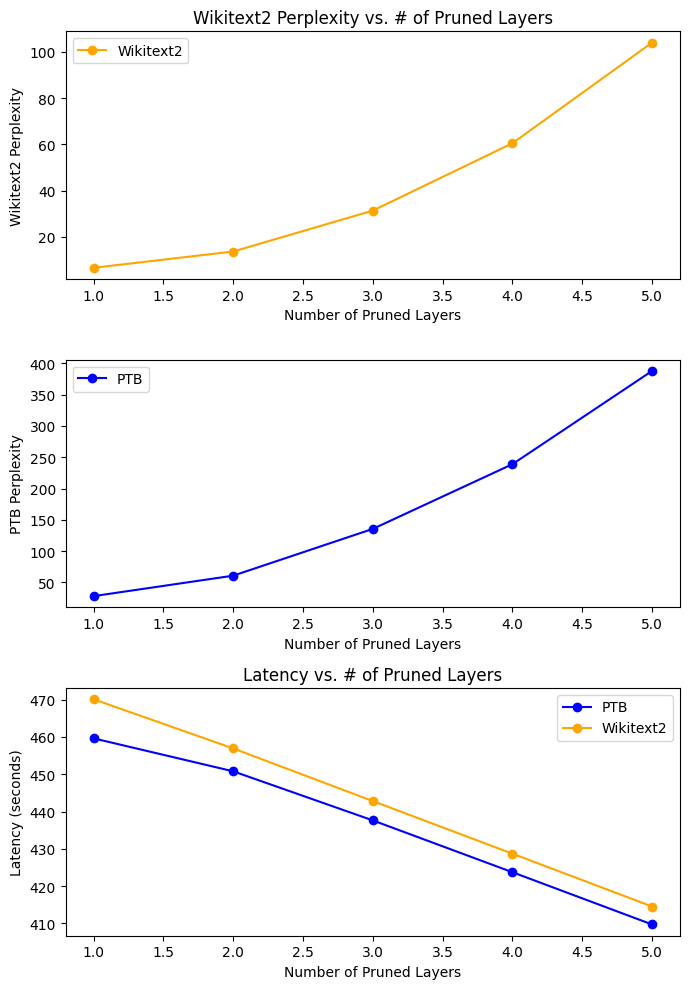

In [9]:
# PTB 데이터셋 결과
num_pruned_layers_ptb = [r[0] for r in results_emp]
sparsities_ptb = [r[1] for r in results_emp]
ppls_ptb = [r[2] for r in results_emp]
latencies_ptb = [r[3] for r in results_emp]

# Wikitext2 데이터셋 결과
num_pruned_layers_wikitext = [r[0] for r in results_emw]
sparsities_wikitext = [r[1] for r in results_emw]
ppls_wikitext = [r[2] for r in results_emw]
latencies_wikitext = [r[3] for r in results_emw]

plt.figure(figsize=(7, 10))

# Wikitext2 Perplexity
plt.subplot(3, 1, 1)
plt.plot(num_pruned_layers_wikitext, ppls_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Wikitext2 Perplexity")
plt.title("Wikitext2 Perplexity vs. # of Pruned Layers")
plt.legend()

# PTB Perplexity
plt.subplot(3, 1, 2)
plt.plot(num_pruned_layers_ptb, ppls_ptb, marker='o', label="PTB", color='b')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("PTB Perplexity")
plt.legend()

# Latency
plt.subplot(3, 1, 3)
plt.plot(num_pruned_layers_ptb, latencies_ptb, marker='o', label="PTB", color='b')
plt.plot(num_pruned_layers_wikitext, latencies_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. # of Pruned Layers")
plt.legend()

plt.tight_layout()
plt.show()


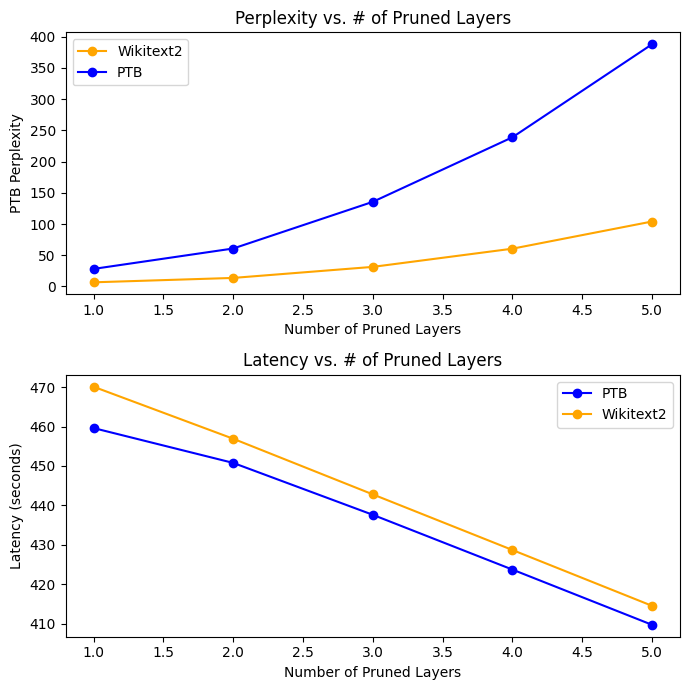

In [5]:
results_emp = [
    (1, 0.03125, 28.084095001220703, 459.6184628009796),
    (2, 0.0625, 60.770809173583984, 450.7812786102295),
    (3, 0.09375, 135.5338134765625, 437.61810064315796),
    (4, 0.125, 238.9453582763672, 423.72305727005005),
    (5, 0.15625, 387.9535217285156, 409.7166986465454)
]

results_emw = [
    (1, 0.03125, 6.604146480560303, 470.1005234718323),
    (2, 0.0625, 13.645593643188477, 456.9097647666931),
    (3, 0.09375, 31.336503982543945, 442.79918122291565),
    (4, 0.125, 60.48569869995117, 428.6912679672241),
    (5, 0.15625, 104.01167297363281, 414.53049516677856)
]

# PTB 데이터셋 결과
num_pruned_layers_ptb = [r[0] for r in results_emp]
sparsities_ptb = [r[1] for r in results_emp]
ppls_ptb = [r[2] for r in results_emp]
latencies_ptb = [r[3] for r in results_emp]

# Wikitext2 데이터셋 결과
num_pruned_layers_wikitext = [r[0] for r in results_emw]
sparsities_wikitext = [r[1] for r in results_emw]
ppls_wikitext = [r[2] for r in results_emw]
latencies_wikitext = [r[3] for r in results_emw]

plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.plot(num_pruned_layers_wikitext, ppls_wikitext, marker='o', label="Wikitext2", color='orange')
plt.plot(num_pruned_layers_ptb, ppls_ptb, marker='o', label="PTB", color='b')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("PTB Perplexity")
plt.title("Perplexity vs. # of Pruned Layers")
plt.legend()

# Latency
plt.subplot(2, 1, 2)
plt.plot(num_pruned_layers_ptb, latencies_ptb, marker='o', label="PTB", color='b')
plt.plot(num_pruned_layers_wikitext, latencies_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. # of Pruned Layers")
plt.legend()

plt.tight_layout()
plt.show()


## Llama-2

In [1]:
import torch
import random
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class EntropyPrunedModel(MistralForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.pruned_layers = set()
        self.entropies = []

    def calculate_entropies(self, input_ids):
        self.entropies = []
        hidden_states = self.model.embed_tokens(input_ids)
        
        with torch.no_grad():
            for layer_module in self.model.layers:
                hidden_states = layer_module(hidden_states)[0]
                logits = self.lm_head(hidden_states[:, -1, :])
                probs = F.softmax(logits, dim=-1)
                top_probs, _ = torch.topk(probs, 10)
                entropy = -torch.sum(top_probs * torch.log(top_probs)).item()
                self.entropies.append(entropy)
    
    def prune_layers_by_entropy_diff(self, num_layers_to_prune):
        if not self.entropies:
            raise ValueError("Entropies not calculated. Please run entropy calculation before pruning.")
        print(np.ndim(self.entropies))
        print(len(self.entropies))
        # print(len(self.entropies[0]))
        entropy_diffs = []
        for i in range(1, len(self.entropies)):
            entropy_diff = self.entropies[i - 1] - self.entropies[i]
            entropy_diffs.append((i, entropy_diff))
        
        # Sort entropy differences in ascending order
        sorted_entropy_diffs = sorted(entropy_diffs, key=lambda x: x[1], reverse=False)
        
        # Select layers with largest entropy difference
        pruned_layers = []
        for i in range(num_layers_to_prune):
            layer_index, entropy_diff = sorted_entropy_diffs[i]
            pruned_layers.append(layer_index)
            print(f"Layer {layer_index}: Entropy Difference = {entropy_diff}")
        
        self.pruned_layers = set(pruned_layers)
    
    def forward(self, input_ids, **kwargs):
        hidden_states = self.model.embed_tokens(input_ids)
        
        for i, layer_module in enumerate(self.model.layers):
            if i in self.pruned_layers:
                continue
            hidden_states = layer_module(hidden_states, **kwargs)[0]
            
        hidden_states = self.model.norm(hidden_states)
        logits = self.lm_head(hidden_states)
        
        return logits

# 모델 로드
directory = "../model/llama_2_7b_hf__meta_llama"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = EntropyPrunedModel.from_pretrained(directory, device_map="auto")

dataset = load_dataset("ptb_text_only", split="test[:15%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

def calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride):
    lls = []
    total_steps = len(split_input_ids)
    passed_samples = 0
    total_samples = 0
    total_length = 0
    start_time = time.time()
    
    for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
        total_samples += 1

        if chunk.size(0) > max_sample_length:
            passed_samples += 1
            continue

        for j in range(0, chunk.size(0), stride):
            begin_loc = max(j + stride - max_length, 0)
            end_loc = min(j + stride, chunk.size(0))
            trg_len = end_loc - j
            total_length += trg_len

            input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
            target_ids = input_ids_chunk.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids_chunk)
                shift_logits = outputs[:, :-1, :].contiguous()
                shift_labels = target_ids[:, 1:].contiguous()
                loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                log_likelihood = loss * trg_len

            lls.append(log_likelihood.cpu())
    
    average_log_likelihood = torch.stack(lls).sum() / total_length
    ppl = torch.exp(average_log_likelihood)
    end_time = time.time()
    latency = end_time - start_time
    
    return ppl.item(), latency

You are using a model of type llama to instantiate a model of type mistral. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
results_elp = []

# 초기 엔트로피 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_entropies(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_entropy_diff(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_elp.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()

1
32
Layer 27: Entropy Difference = -0.19051611423492432
Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:42<00:00, 27.20s/it]


Perplexity: 20.50360107421875, Latency: 462.44361996650696 seconds
1
32
Layer 27: Entropy Difference = -0.19051611423492432
Layer 26: Entropy Difference = -0.18809711933135986
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:30<00:00, 26.50s/it]


Perplexity: 21.534778594970703, Latency: 450.4682619571686 seconds
1
32
Layer 27: Entropy Difference = -0.19051611423492432
Layer 26: Entropy Difference = -0.18809711933135986
Layer 25: Entropy Difference = -0.10183906555175781
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:16<00:00, 25.70s/it]


Perplexity: 23.4315242767334, Latency: 436.8283896446228 seconds
1
32
Layer 27: Entropy Difference = -0.19051611423492432
Layer 26: Entropy Difference = -0.18809711933135986
Layer 25: Entropy Difference = -0.10183906555175781
Layer 22: Entropy Difference = -0.06608928740024567
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [06:59<00:00, 24.69s/it]


Perplexity: 25.465028762817383, Latency: 419.6826310157776 seconds
1
32
Layer 27: Entropy Difference = -0.19051611423492432
Layer 26: Entropy Difference = -0.18809711933135986
Layer 25: Entropy Difference = -0.10183906555175781
Layer 22: Entropy Difference = -0.06608928740024567
Layer 23: Entropy Difference = -0.048822835087776184
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:42<00:00, 23.71s/it]

Perplexity: 27.819957733154297, Latency: 402.9953737258911 seconds


In [3]:
results_elp

[(1, 0.03125, 20.50360107421875, 462.44361996650696),
 (2, 0.0625, 21.534778594970703, 450.4682619571686),
 (3, 0.09375, 23.4315242767334, 436.8283896446228),
 (4, 0.125, 25.465028762817383, 419.6826310157776),
 (5, 0.15625, 27.819957733154297, 402.9953737258911)]

In [4]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

split_input_ids = split_long_text(input_ids, max_sample_length)

In [5]:
results_elw = []

# 초기 엔트로피 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_entropies(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_entropy_diff(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_elw.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()

1
32
Layer 29: Entropy Difference = -0.6603612899780273
Pruned 1 layers (sparsity: 3.12%)


Processing: 100%|██████████| 17/17 [07:37<00:00, 26.94s/it]


Perplexity: 6.5146002769470215, Latency: 457.90588760375977 seconds
1
32
Layer 29: Entropy Difference = -0.6603612899780273
Layer 28: Entropy Difference = -0.559985838830471
Pruned 2 layers (sparsity: 6.25%)


Processing: 100%|██████████| 17/17 [07:24<00:00, 26.17s/it]


Perplexity: 7.472212314605713, Latency: 444.96508264541626 seconds
1
32
Layer 29: Entropy Difference = -0.6603612899780273
Layer 28: Entropy Difference = -0.559985838830471
Layer 20: Entropy Difference = -0.270833820104599
Pruned 3 layers (sparsity: 9.38%)


Processing: 100%|██████████| 17/17 [07:08<00:00, 25.19s/it]


Perplexity: 8.191120147705078, Latency: 428.2281594276428 seconds
1
32
Layer 29: Entropy Difference = -0.6603612899780273
Layer 28: Entropy Difference = -0.559985838830471
Layer 20: Entropy Difference = -0.270833820104599
Layer 31: Entropy Difference = -0.20107871294021606
Pruned 4 layers (sparsity: 12.50%)


Processing: 100%|██████████| 17/17 [06:54<00:00, 24.40s/it]


Perplexity: 15.921226501464844, Latency: 414.8356816768646 seconds
1
32
Layer 29: Entropy Difference = -0.6603612899780273
Layer 28: Entropy Difference = -0.559985838830471
Layer 20: Entropy Difference = -0.270833820104599
Layer 31: Entropy Difference = -0.20107871294021606
Layer 19: Entropy Difference = -0.09159867465496063
Pruned 5 layers (sparsity: 15.62%)


Processing: 100%|██████████| 17/17 [06:37<00:00, 23.41s/it]

Perplexity: 17.96168327331543, Latency: 397.94642782211304 seconds


In [6]:
results_elw

[(1, 0.03125, 6.5146002769470215, 457.90588760375977),
 (2, 0.0625, 7.472212314605713, 444.96508264541626),
 (3, 0.09375, 8.191120147705078, 428.2281594276428),
 (4, 0.125, 15.921226501464844, 414.8356816768646),
 (5, 0.15625, 17.96168327331543, 397.94642782211304)]

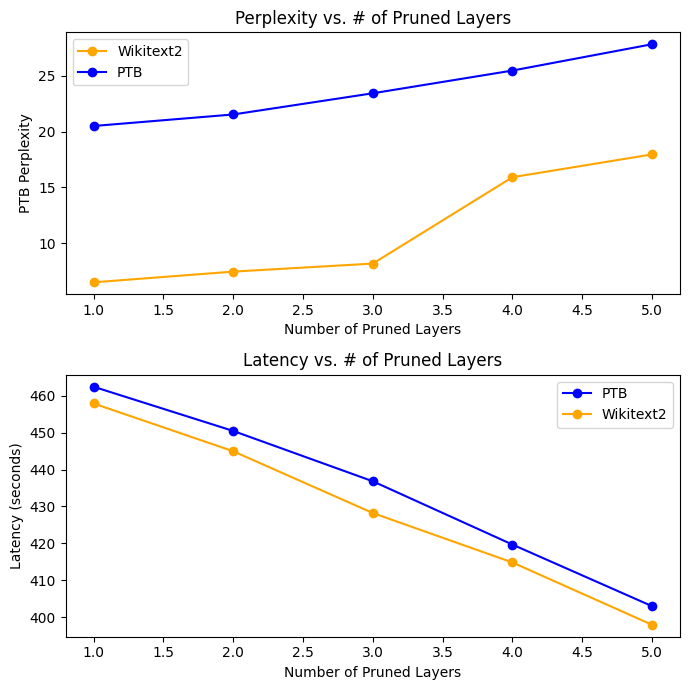

In [7]:
# PTB 데이터셋 결과
num_pruned_layers_ptb = [r[0] for r in results_elp]
sparsities_ptb = [r[1] for r in results_elp]
ppls_ptb = [r[2] for r in results_elp]
latencies_ptb = [r[3] for r in results_elp]

# Wikitext2 데이터셋 결과
num_pruned_layers_wikitext = [r[0] for r in results_elw]
sparsities_wikitext = [r[1] for r in results_elw]
ppls_wikitext = [r[2] for r in results_elw]
latencies_wikitext = [r[3] for r in results_elw]

plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.plot(num_pruned_layers_wikitext, ppls_wikitext, marker='o', label="Wikitext2", color='orange')
plt.plot(num_pruned_layers_ptb, ppls_ptb, marker='o', label="PTB", color='b')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("PTB Perplexity")
plt.title("Perplexity vs. # of Pruned Layers")
plt.legend()

# Latency
plt.subplot(2, 1, 2)
plt.plot(num_pruned_layers_ptb, latencies_ptb, marker='o', label="PTB", color='b')
plt.plot(num_pruned_layers_wikitext, latencies_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. # of Pruned Layers")
plt.legend()

plt.tight_layout()
plt.show()


# Confidence-based

## Mistral

In [1]:
import torch
import random
import torch.nn.functional as F
from transformers import MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class ConfidencePrunedModel(MistralForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.pruned_layers = set()
        self.confidences = []

    def calculate_confidences(self, input_ids):
        self.confidences = []
        hidden_states = self.model.embed_tokens(input_ids)
        
        with torch.no_grad():
            for layer_module in self.model.layers:
                hidden_states = layer_module(hidden_states)[0]
                logits = self.lm_head(hidden_states[:, -1, :])
                probs = F.softmax(logits, dim=-1)
                top_confidence, _ = torch.max(probs, dim=-1)
                confidence = top_confidence.mean().item()
                self.confidences.append(confidence)

    def prune_layers_by_confidence(self, num_layers_to_prune):
        if not self.confidences:
            raise ValueError("Confidences not calculated. Please run confidence calculation before pruning.")
        
        # Calculate confidence differences
        confidence_diffs = [self.confidences[i] - self.confidences[i - 1] for i in range(1, len(self.confidences))]
        
        # Display sorted confidence differences and corresponding layers
        sorted_indices = np.argsort(confidence_diffs)  # asc
        
        print("Sorted confidence differences and corresponding layer indices:")
        for idx in sorted_indices:
            print(f"Layer {idx}: Confidence Difference = {confidence_diffs[idx]}")
        
        # Select layers with smallest confidence difference
        layers_to_prune = sorted_indices[:num_layers_to_prune]
        self.pruned_layers = set(layers_to_prune)
        
        # Display pruned layers
        print(f"Pruned layers: {self.pruned_layers}")

    def forward(self, input_ids, **kwargs):
        hidden_states = self.model.embed_tokens(input_ids)
        
        for i, layer_module in enumerate(self.model.layers):
            if i in self.pruned_layers:
                continue
            hidden_states = layer_module(hidden_states, **kwargs)[0]
            
        hidden_states = self.model.norm(hidden_states)
        logits = self.lm_head(hidden_states)
        
        return logits

# 모델 로드
directory = "../model/mistral_7b_v01__MistralAI"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = ConfidencePrunedModel.from_pretrained(directory, device_map="auto")

# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test[:15%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

def calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride):
    lls = []
    total_steps = len(split_input_ids)
    passed_samples = 0
    total_samples = 0
    total_length = 0
    start_time = time.time()
    
    for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
        total_samples += 1

        if chunk.size(0) > max_sample_length:
            passed_samples += 1
            continue

        for j in range(0, chunk.size(0), stride):
            begin_loc = max(j + stride - max_length, 0)
            end_loc = min(j + stride, chunk.size(0))
            trg_len = end_loc - j
            total_length += trg_len

            input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
            target_ids = input_ids_chunk.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids_chunk)
                shift_logits = outputs[:, :-1, :].contiguous()
                shift_labels = target_ids[:, 1:].contiguous()
                loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                log_likelihood = loss * trg_len

            lls.append(log_likelihood.cpu())
    
    average_log_likelihood = torch.stack(lls).sum() / total_length
    ppl = torch.exp(average_log_likelihood)
    end_time = time.time()
    latency = end_time - start_time
    
    return ppl.item(), latency

results_cmp = []

# 초기 confidence 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_confidences(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_confidence(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_cmp.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Sorted confidence differences and corresponding layer indices:
Layer 19: Confidence Difference = -1.2696546036750078e-06
Layer 24: Confidence Difference = -3.5175253287889063e-07
Layer 1: Confidence Difference = 6.289701559580863e-08
Layer 6: Confidence Difference = 6.93617039360106e-08
Layer 0: Confidence Difference = 7.417838787660003e-08
Layer 8: Confidence Difference = 9.164068615064025e-08
Layer 3: Confidence Difference = 9.711948223412037e-08
Layer 4: Confidence Difference = 1.301195879932493e-07
Layer 11: Confidence Difference = 1.4054967323318124e-07
Layer 2: Confidence Difference = 1.776570570655167e-07
Layer 10: Confidence Difference = 2.1202504285611212e-07
Layer 14: Confidence Difference = 3.0024239094927907e-07
Layer 5: Confidence Difference = 3.53076757164672e-07
Layer 7: Confidence Difference = 3.9787482819519937e-07
Layer 15: Confidence Difference = 5.67040842724964e-07
Layer 13: Confidence Difference = 5.852234608028084e-07
Layer 23: Confidence Difference = 5.891743057

Processing: 100%|██████████| 17/17 [07:43<00:00, 27.24s/it]


Perplexity: 27.487770080566406, Latency: 463.1498849391937 seconds
Sorted confidence differences and corresponding layer indices:
Layer 19: Confidence Difference = -1.2696546036750078e-06
Layer 24: Confidence Difference = -3.5175253287889063e-07
Layer 1: Confidence Difference = 6.289701559580863e-08
Layer 6: Confidence Difference = 6.93617039360106e-08
Layer 0: Confidence Difference = 7.417838787660003e-08
Layer 8: Confidence Difference = 9.164068615064025e-08
Layer 3: Confidence Difference = 9.711948223412037e-08
Layer 4: Confidence Difference = 1.301195879932493e-07
Layer 11: Confidence Difference = 1.4054967323318124e-07
Layer 2: Confidence Difference = 1.776570570655167e-07
Layer 10: Confidence Difference = 2.1202504285611212e-07
Layer 14: Confidence Difference = 3.0024239094927907e-07
Layer 5: Confidence Difference = 3.53076757164672e-07
Layer 7: Confidence Difference = 3.9787482819519937e-07
Layer 15: Confidence Difference = 5.67040842724964e-07
Layer 13: Confidence Difference = 

Processing: 100%|██████████| 17/17 [07:29<00:00, 26.45s/it]


Perplexity: 29.539669036865234, Latency: 449.6867744922638 seconds
Sorted confidence differences and corresponding layer indices:
Layer 19: Confidence Difference = -1.2696546036750078e-06
Layer 24: Confidence Difference = -3.5175253287889063e-07
Layer 1: Confidence Difference = 6.289701559580863e-08
Layer 6: Confidence Difference = 6.93617039360106e-08
Layer 0: Confidence Difference = 7.417838787660003e-08
Layer 8: Confidence Difference = 9.164068615064025e-08
Layer 3: Confidence Difference = 9.711948223412037e-08
Layer 4: Confidence Difference = 1.301195879932493e-07
Layer 11: Confidence Difference = 1.4054967323318124e-07
Layer 2: Confidence Difference = 1.776570570655167e-07
Layer 10: Confidence Difference = 2.1202504285611212e-07
Layer 14: Confidence Difference = 3.0024239094927907e-07
Layer 5: Confidence Difference = 3.53076757164672e-07
Layer 7: Confidence Difference = 3.9787482819519937e-07
Layer 15: Confidence Difference = 5.67040842724964e-07
Layer 13: Confidence Difference = 

Processing: 100%|██████████| 17/17 [07:16<00:00, 25.66s/it]


Perplexity: 260.2650146484375, Latency: 436.2645494937897 seconds
Sorted confidence differences and corresponding layer indices:
Layer 19: Confidence Difference = -1.2696546036750078e-06
Layer 24: Confidence Difference = -3.5175253287889063e-07
Layer 1: Confidence Difference = 6.289701559580863e-08
Layer 6: Confidence Difference = 6.93617039360106e-08
Layer 0: Confidence Difference = 7.417838787660003e-08
Layer 8: Confidence Difference = 9.164068615064025e-08
Layer 3: Confidence Difference = 9.711948223412037e-08
Layer 4: Confidence Difference = 1.301195879932493e-07
Layer 11: Confidence Difference = 1.4054967323318124e-07
Layer 2: Confidence Difference = 1.776570570655167e-07
Layer 10: Confidence Difference = 2.1202504285611212e-07
Layer 14: Confidence Difference = 3.0024239094927907e-07
Layer 5: Confidence Difference = 3.53076757164672e-07
Layer 7: Confidence Difference = 3.9787482819519937e-07
Layer 15: Confidence Difference = 5.67040842724964e-07
Layer 13: Confidence Difference = 5

Processing: 100%|██████████| 17/17 [07:02<00:00, 24.86s/it]


Perplexity: 234.7811737060547, Latency: 422.54423356056213 seconds
Sorted confidence differences and corresponding layer indices:
Layer 19: Confidence Difference = -1.2696546036750078e-06
Layer 24: Confidence Difference = -3.5175253287889063e-07
Layer 1: Confidence Difference = 6.289701559580863e-08
Layer 6: Confidence Difference = 6.93617039360106e-08
Layer 0: Confidence Difference = 7.417838787660003e-08
Layer 8: Confidence Difference = 9.164068615064025e-08
Layer 3: Confidence Difference = 9.711948223412037e-08
Layer 4: Confidence Difference = 1.301195879932493e-07
Layer 11: Confidence Difference = 1.4054967323318124e-07
Layer 2: Confidence Difference = 1.776570570655167e-07
Layer 10: Confidence Difference = 2.1202504285611212e-07
Layer 14: Confidence Difference = 3.0024239094927907e-07
Layer 5: Confidence Difference = 3.53076757164672e-07
Layer 7: Confidence Difference = 3.9787482819519937e-07
Layer 15: Confidence Difference = 5.67040842724964e-07
Layer 13: Confidence Difference = 

Processing: 100%|██████████| 17/17 [06:48<00:00, 24.01s/it]

Perplexity: 6770.55419921875, Latency: 408.1932923793793 seconds


In [3]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

split_input_ids = split_long_text(input_ids, max_sample_length)

results_cmw = []

# 초기 엔트로피 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_confidences(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_confidence(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_cmw.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()

Sorted confidence differences and corresponding layer indices:
Layer 25: Confidence Difference = -4.2708488763310015e-06
Layer 14: Confidence Difference = -3.287095751147717e-07
Layer 7: Confidence Difference = 5.687979864887893e-08
Layer 4: Confidence Difference = 8.933056960813701e-08
Layer 3: Confidence Difference = 1.1713927960954607e-07
Layer 0: Confidence Difference = 1.3548560673370957e-07
Layer 5: Confidence Difference = 1.922417141031474e-07
Layer 6: Confidence Difference = 2.004926500376314e-07
Layer 8: Confidence Difference = 2.3147003958001733e-07
Layer 1: Confidence Difference = 2.621636667754501e-07
Layer 2: Confidence Difference = 2.713968569878489e-07
Layer 11: Confidence Difference = 2.903943823184818e-07
Layer 9: Confidence Difference = 4.276262188795954e-07
Layer 17: Confidence Difference = 4.490830178838223e-07
Layer 10: Confidence Difference = 5.779256753157824e-07
Layer 12: Confidence Difference = 7.688577170483768e-07
Layer 13: Confidence Difference = 8.705937943

Processing: 100%|██████████| 17/17 [07:53<00:00, 27.87s/it]


Perplexity: 5.936453819274902, Latency: 473.7537519931793 seconds
Sorted confidence differences and corresponding layer indices:
Layer 25: Confidence Difference = -4.2708488763310015e-06
Layer 14: Confidence Difference = -3.287095751147717e-07
Layer 7: Confidence Difference = 5.687979864887893e-08
Layer 4: Confidence Difference = 8.933056960813701e-08
Layer 3: Confidence Difference = 1.1713927960954607e-07
Layer 0: Confidence Difference = 1.3548560673370957e-07
Layer 5: Confidence Difference = 1.922417141031474e-07
Layer 6: Confidence Difference = 2.004926500376314e-07
Layer 8: Confidence Difference = 2.3147003958001733e-07
Layer 1: Confidence Difference = 2.621636667754501e-07
Layer 2: Confidence Difference = 2.713968569878489e-07
Layer 11: Confidence Difference = 2.903943823184818e-07
Layer 9: Confidence Difference = 4.276262188795954e-07
Layer 17: Confidence Difference = 4.490830178838223e-07
Layer 10: Confidence Difference = 5.779256753157824e-07
Layer 12: Confidence Difference = 7

Processing: 100%|██████████| 17/17 [07:44<00:00, 27.30s/it]


Perplexity: 6.30670166015625, Latency: 464.18192887306213 seconds
Sorted confidence differences and corresponding layer indices:
Layer 25: Confidence Difference = -4.2708488763310015e-06
Layer 14: Confidence Difference = -3.287095751147717e-07
Layer 7: Confidence Difference = 5.687979864887893e-08
Layer 4: Confidence Difference = 8.933056960813701e-08
Layer 3: Confidence Difference = 1.1713927960954607e-07
Layer 0: Confidence Difference = 1.3548560673370957e-07
Layer 5: Confidence Difference = 1.922417141031474e-07
Layer 6: Confidence Difference = 2.004926500376314e-07
Layer 8: Confidence Difference = 2.3147003958001733e-07
Layer 1: Confidence Difference = 2.621636667754501e-07
Layer 2: Confidence Difference = 2.713968569878489e-07
Layer 11: Confidence Difference = 2.903943823184818e-07
Layer 9: Confidence Difference = 4.276262188795954e-07
Layer 17: Confidence Difference = 4.490830178838223e-07
Layer 10: Confidence Difference = 5.779256753157824e-07
Layer 12: Confidence Difference = 7

Processing: 100%|██████████| 17/17 [07:30<00:00, 26.50s/it]


Perplexity: 6.8461594581604, Latency: 450.43216490745544 seconds
Sorted confidence differences and corresponding layer indices:
Layer 25: Confidence Difference = -4.2708488763310015e-06
Layer 14: Confidence Difference = -3.287095751147717e-07
Layer 7: Confidence Difference = 5.687979864887893e-08
Layer 4: Confidence Difference = 8.933056960813701e-08
Layer 3: Confidence Difference = 1.1713927960954607e-07
Layer 0: Confidence Difference = 1.3548560673370957e-07
Layer 5: Confidence Difference = 1.922417141031474e-07
Layer 6: Confidence Difference = 2.004926500376314e-07
Layer 8: Confidence Difference = 2.3147003958001733e-07
Layer 1: Confidence Difference = 2.621636667754501e-07
Layer 2: Confidence Difference = 2.713968569878489e-07
Layer 11: Confidence Difference = 2.903943823184818e-07
Layer 9: Confidence Difference = 4.276262188795954e-07
Layer 17: Confidence Difference = 4.490830178838223e-07
Layer 10: Confidence Difference = 5.779256753157824e-07
Layer 12: Confidence Difference = 7.

Processing: 100%|██████████| 17/17 [07:16<00:00, 25.67s/it]


Perplexity: 8.195504188537598, Latency: 436.3672342300415 seconds
Sorted confidence differences and corresponding layer indices:
Layer 25: Confidence Difference = -4.2708488763310015e-06
Layer 14: Confidence Difference = -3.287095751147717e-07
Layer 7: Confidence Difference = 5.687979864887893e-08
Layer 4: Confidence Difference = 8.933056960813701e-08
Layer 3: Confidence Difference = 1.1713927960954607e-07
Layer 0: Confidence Difference = 1.3548560673370957e-07
Layer 5: Confidence Difference = 1.922417141031474e-07
Layer 6: Confidence Difference = 2.004926500376314e-07
Layer 8: Confidence Difference = 2.3147003958001733e-07
Layer 1: Confidence Difference = 2.621636667754501e-07
Layer 2: Confidence Difference = 2.713968569878489e-07
Layer 11: Confidence Difference = 2.903943823184818e-07
Layer 9: Confidence Difference = 4.276262188795954e-07
Layer 17: Confidence Difference = 4.490830178838223e-07
Layer 10: Confidence Difference = 5.779256753157824e-07
Layer 12: Confidence Difference = 7

Processing: 100%|██████████| 17/17 [07:02<00:00, 24.83s/it]

Perplexity: 12.885787010192871, Latency: 422.13383173942566 seconds


In [4]:
results_cmp

[(1, 0.03125, 27.487770080566406, 463.1498849391937),
 (2, 0.0625, 29.539669036865234, 449.6867744922638),
 (3, 0.09375, 260.2650146484375, 436.2645494937897),
 (4, 0.125, 234.7811737060547, 422.54423356056213),
 (5, 0.15625, 6770.55419921875, 408.1932923793793)]

In [5]:
results_cmw

[(1, 0.03125, 5.936453819274902, 473.7537519931793),
 (2, 0.0625, 6.30670166015625, 464.18192887306213),
 (3, 0.09375, 6.8461594581604, 450.43216490745544),
 (4, 0.125, 8.195504188537598, 436.3672342300415),
 (5, 0.15625, 12.885787010192871, 422.13383173942566)]

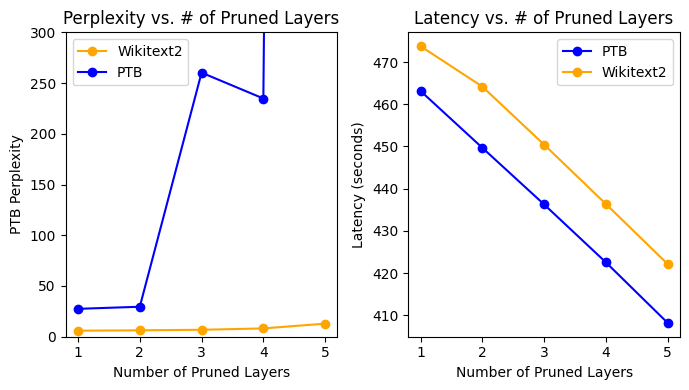

In [7]:
# PTB 데이터셋 결과
num_pruned_layers_ptb = [r[0] for r in results_cmp]
sparsities_ptb = [r[1] for r in results_cmp]
ppls_ptb = [r[2] for r in results_cmp]
latencies_ptb = [r[3] for r in results_cmp]

# Wikitext2 데이터셋 결과
num_pruned_layers_wikitext = [r[0] for r in results_cmw]
sparsities_wikitext = [r[1] for r in results_cmw]
ppls_wikitext = [r[2] for r in results_cmw]
latencies_wikitext = [r[3] for r in results_cmw]

plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(num_pruned_layers_wikitext, ppls_wikitext, marker='o', label="Wikitext2", color='orange')
plt.plot(num_pruned_layers_ptb, ppls_ptb, marker='o', label="PTB", color='b')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("PTB Perplexity")
plt.ylim(0, 300)
plt.title("Perplexity vs. # of Pruned Layers")
plt.legend()

# Latency
plt.subplot(1, 2, 2)
plt.plot(num_pruned_layers_ptb, latencies_ptb, marker='o', label="PTB", color='b')
plt.plot(num_pruned_layers_wikitext, latencies_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. # of Pruned Layers")
plt.legend()

plt.tight_layout()
plt.show()


## Llama-2

In [1]:
import torch
import random
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, MistralForCausalLM, AutoTokenizer
from datasets import load_dataset
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class ConfidencePrunedModel(MistralForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        self.pruned_layers = set()
        self.confidences = []

    def calculate_confidences(self, input_ids):
        self.confidences = []
        hidden_states = self.model.embed_tokens(input_ids)
        
        with torch.no_grad():
            for layer_module in self.model.layers:
                hidden_states = layer_module(hidden_states)[0]
                logits = self.lm_head(hidden_states[:, -1, :])
                probs = F.softmax(logits, dim=-1)
                top_confidence, _ = torch.max(probs, dim=-1)
                confidence = top_confidence.mean().item()
                self.confidences.append(confidence)

    def prune_layers_by_confidence(self, num_layers_to_prune):
        if not self.confidences:
            raise ValueError("Confidences not calculated. Please run confidence calculation before pruning.")
        
        # Calculate confidence differences
        confidence_diffs = [self.confidences[i] - self.confidences[i - 1] for i in range(1, len(self.confidences))]
        
        # Display sorted confidence differences and corresponding layers
        sorted_indices = np.argsort(confidence_diffs)  # asc
        
        print("Sorted confidence differences and corresponding layer indices:")
        for idx in sorted_indices:
            print(f"Layer {idx}: Confidence Difference = {confidence_diffs[idx]}")
        
        # Select layers with smallest confidence difference
        layers_to_prune = sorted_indices[:num_layers_to_prune]
        self.pruned_layers = set(layers_to_prune)
        
        # Display pruned layers
        print(f"Pruned layers: {self.pruned_layers}")

    def forward(self, input_ids, **kwargs):
        hidden_states = self.model.embed_tokens(input_ids)
        
        for i, layer_module in enumerate(self.model.layers):
            if i in self.pruned_layers:
                continue
            hidden_states = layer_module(hidden_states, **kwargs)[0]
            
        hidden_states = self.model.norm(hidden_states)
        logits = self.lm_head(hidden_states)
        
        return logits

# 모델 로드
directory = "../model/llama_2_7b_hf__meta_llama"
tokenizer = AutoTokenizer.from_pretrained(directory)
model = ConfidencePrunedModel.from_pretrained(directory, device_map="auto")

# PTB 데이터셋 사용
dataset = load_dataset("ptb_text_only", split="test[:15%]", trust_remote_code=True)  # PTB 데이터셋의 테스트 split 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["sentence"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

# 최대 길이를 초과하는 텍스트 분할
def split_long_text(input_ids, max_sample_length):
    split_input_ids = []
    for i in range(0, len(input_ids), max_sample_length):
        split_input_ids.append(input_ids[i:i + max_sample_length])
    return split_input_ids

split_input_ids = split_long_text(input_ids, max_sample_length)

def calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride):
    lls = []
    total_steps = len(split_input_ids)
    passed_samples = 0
    total_samples = 0
    total_length = 0
    start_time = time.time()
    
    for i, chunk in enumerate(tqdm(split_input_ids, total=total_steps, desc="Processing")):
        total_samples += 1

        if chunk.size(0) > max_sample_length:
            passed_samples += 1
            continue

        for j in range(0, chunk.size(0), stride):
            begin_loc = max(j + stride - max_length, 0)
            end_loc = min(j + stride, chunk.size(0))
            trg_len = end_loc - j
            total_length += trg_len

            input_ids_chunk = chunk[begin_loc:end_loc].unsqueeze(0).to('cuda')
            target_ids = input_ids_chunk.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids_chunk)
                shift_logits = outputs[:, :-1, :].contiguous()
                shift_labels = target_ids[:, 1:].contiguous()
                loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                log_likelihood = loss * trg_len

            lls.append(log_likelihood.cpu())
    
    average_log_likelihood = torch.stack(lls).sum() / total_length
    ppl = torch.exp(average_log_likelihood)
    end_time = time.time()
    latency = end_time - start_time
    
    return ppl.item(), latency

results_clp = []

# 초기 confidence 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_confidences(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_confidence(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_clp.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()


You are using a model of type llama to instantiate a model of type mistral. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Sorted confidence differences and corresponding layer indices:
Layer 30: Confidence Difference = -0.0009275674819946289
Layer 20: Confidence Difference = -0.0004476672038435936
Layer 13: Confidence Difference = -9.885930921882391e-06
Layer 3: Confidence Difference = -4.374269337859005e-07
Layer 0: Confidence Difference = 6.846421456430107e-07
Layer 7: Confidence Difference = 1.400680048391223e-06
Layer 1: Confidence Difference = 3.3649666875135154e-06
Layer 6: Confidence Difference = 3.833927621599287e-06
Layer 9: Confidence Difference = 5.130255885887891e-06
Layer 2: Confidence Difference = 5.819027137476951e-06
Layer 5: Confidence Difference = 7.3775700002443045e-06
Layer 4: Confidence Difference = 8.693943527759984e-06
Layer 8: Confidence Difference = 1.546991552459076e-05
Layer 10: Confidence Difference = 1.909127604449168e-05
Layer 11: Confidence Difference = 2.703563222894445e-05
Layer 12: Confidence Difference = 3.969950194004923e-05
Layer 14: Confidence Difference = 4.822704067

Processing: 100%|██████████| 17/17 [07:34<00:00, 26.72s/it]


Perplexity: 21.972270965576172, Latency: 454.26698565483093 seconds
Sorted confidence differences and corresponding layer indices:
Layer 30: Confidence Difference = -0.0009275674819946289
Layer 20: Confidence Difference = -0.0004476672038435936
Layer 13: Confidence Difference = -9.885930921882391e-06
Layer 3: Confidence Difference = -4.374269337859005e-07
Layer 0: Confidence Difference = 6.846421456430107e-07
Layer 7: Confidence Difference = 1.400680048391223e-06
Layer 1: Confidence Difference = 3.3649666875135154e-06
Layer 6: Confidence Difference = 3.833927621599287e-06
Layer 9: Confidence Difference = 5.130255885887891e-06
Layer 2: Confidence Difference = 5.819027137476951e-06
Layer 5: Confidence Difference = 7.3775700002443045e-06
Layer 4: Confidence Difference = 8.693943527759984e-06
Layer 8: Confidence Difference = 1.546991552459076e-05
Layer 10: Confidence Difference = 1.909127604449168e-05
Layer 11: Confidence Difference = 2.703563222894445e-05
Layer 12: Confidence Difference =

Processing: 100%|██████████| 17/17 [07:23<00:00, 26.10s/it]


Perplexity: 23.231170654296875, Latency: 443.6237030029297 seconds
Sorted confidence differences and corresponding layer indices:
Layer 30: Confidence Difference = -0.0009275674819946289
Layer 20: Confidence Difference = -0.0004476672038435936
Layer 13: Confidence Difference = -9.885930921882391e-06
Layer 3: Confidence Difference = -4.374269337859005e-07
Layer 0: Confidence Difference = 6.846421456430107e-07
Layer 7: Confidence Difference = 1.400680048391223e-06
Layer 1: Confidence Difference = 3.3649666875135154e-06
Layer 6: Confidence Difference = 3.833927621599287e-06
Layer 9: Confidence Difference = 5.130255885887891e-06
Layer 2: Confidence Difference = 5.819027137476951e-06
Layer 5: Confidence Difference = 7.3775700002443045e-06
Layer 4: Confidence Difference = 8.693943527759984e-06
Layer 8: Confidence Difference = 1.546991552459076e-05
Layer 10: Confidence Difference = 1.909127604449168e-05
Layer 11: Confidence Difference = 2.703563222894445e-05
Layer 12: Confidence Difference = 

Processing: 100%|██████████| 17/17 [07:10<00:00, 25.33s/it]


Perplexity: 25.440210342407227, Latency: 430.69585371017456 seconds
Sorted confidence differences and corresponding layer indices:
Layer 30: Confidence Difference = -0.0009275674819946289
Layer 20: Confidence Difference = -0.0004476672038435936
Layer 13: Confidence Difference = -9.885930921882391e-06
Layer 3: Confidence Difference = -4.374269337859005e-07
Layer 0: Confidence Difference = 6.846421456430107e-07
Layer 7: Confidence Difference = 1.400680048391223e-06
Layer 1: Confidence Difference = 3.3649666875135154e-06
Layer 6: Confidence Difference = 3.833927621599287e-06
Layer 9: Confidence Difference = 5.130255885887891e-06
Layer 2: Confidence Difference = 5.819027137476951e-06
Layer 5: Confidence Difference = 7.3775700002443045e-06
Layer 4: Confidence Difference = 8.693943527759984e-06
Layer 8: Confidence Difference = 1.546991552459076e-05
Layer 10: Confidence Difference = 1.909127604449168e-05
Layer 11: Confidence Difference = 2.703563222894445e-05
Layer 12: Confidence Difference =

Processing: 100%|██████████| 17/17 [06:57<00:00, 24.54s/it]


Perplexity: 36.3902702331543, Latency: 417.228351354599 seconds
Sorted confidence differences and corresponding layer indices:
Layer 30: Confidence Difference = -0.0009275674819946289
Layer 20: Confidence Difference = -0.0004476672038435936
Layer 13: Confidence Difference = -9.885930921882391e-06
Layer 3: Confidence Difference = -4.374269337859005e-07
Layer 0: Confidence Difference = 6.846421456430107e-07
Layer 7: Confidence Difference = 1.400680048391223e-06
Layer 1: Confidence Difference = 3.3649666875135154e-06
Layer 6: Confidence Difference = 3.833927621599287e-06
Layer 9: Confidence Difference = 5.130255885887891e-06
Layer 2: Confidence Difference = 5.819027137476951e-06
Layer 5: Confidence Difference = 7.3775700002443045e-06
Layer 4: Confidence Difference = 8.693943527759984e-06
Layer 8: Confidence Difference = 1.546991552459076e-05
Layer 10: Confidence Difference = 1.909127604449168e-05
Layer 11: Confidence Difference = 2.703563222894445e-05
Layer 12: Confidence Difference = 3.9

Processing: 100%|██████████| 17/17 [06:43<00:00, 23.72s/it]

Perplexity: 24279.306640625, Latency: 403.2637720108032 seconds


In [2]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:5%]")  # 데이터셋의 5%만 사용
max_length = model.config.max_position_embeddings
stride = 32
max_sample_length = 1024  # 설정 가능한 최대 샘플 길이

# 데이터 전처리: 일정 크기가 넘는 샘플은 잘라서 처리
texts = "\n\n".join(dataset["text"])
tokens = tokenizer(texts, return_tensors="pt")
input_ids = tokens.input_ids[0]

split_input_ids = split_long_text(input_ids, max_sample_length)

results_clw = []

# 초기 엔트로피 계산
input_ids_sample = split_input_ids[0][:32].unsqueeze(0).to('cuda')  # 첫 번째 문장의 일부 사용
model.calculate_confidences(input_ids_sample)

for num_pruned_layers in range(1, 6):  # 1에서 5까지
    model.prune_layers_by_confidence(num_pruned_layers)
    sparsity = num_pruned_layers / len(model.model.layers)
    print(f"Pruned {num_pruned_layers} layers (sparsity: {sparsity*100:.2f}%)")
    
    ppl, latency = calculate_perplexity_and_latency(model, split_input_ids, max_sample_length, stride)
    results_clw.append((num_pruned_layers, sparsity, ppl, latency))
    print(f"Perplexity: {ppl}, Latency: {latency} seconds")
    
    # Reset the model to unpruned state
    model.pruned_layers = set()

Sorted confidence differences and corresponding layer indices:
Layer 28: Confidence Difference = -0.27245575189590454
Layer 27: Confidence Difference = -0.12961095571517944
Layer 30: Confidence Difference = -0.04082375764846802
Layer 26: Confidence Difference = -0.0026807188987731934
Layer 24: Confidence Difference = -0.002172708511352539
Layer 11: Confidence Difference = -1.02266640169546e-05
Layer 9: Confidence Difference = -5.865156708750874e-06
Layer 4: Confidence Difference = -4.911027644993737e-06
Layer 0: Confidence Difference = 2.528497134335339e-06
Layer 5: Confidence Difference = 4.260557034285739e-06
Layer 2: Confidence Difference = 5.329737177817151e-06
Layer 1: Confidence Difference = 6.110480171628296e-06
Layer 7: Confidence Difference = 8.224968041758984e-06
Layer 6: Confidence Difference = 8.651364623801783e-06
Layer 3: Confidence Difference = 8.906274160835892e-06
Layer 10: Confidence Difference = 2.0298502931836993e-05
Layer 13: Confidence Difference = 2.1114930859766

Processing: 100%|██████████| 17/17 [07:34<00:00, 26.75s/it]


Perplexity: 6.276174545288086, Latency: 454.70400404930115 seconds
Sorted confidence differences and corresponding layer indices:
Layer 28: Confidence Difference = -0.27245575189590454
Layer 27: Confidence Difference = -0.12961095571517944
Layer 30: Confidence Difference = -0.04082375764846802
Layer 26: Confidence Difference = -0.0026807188987731934
Layer 24: Confidence Difference = -0.002172708511352539
Layer 11: Confidence Difference = -1.02266640169546e-05
Layer 9: Confidence Difference = -5.865156708750874e-06
Layer 4: Confidence Difference = -4.911027644993737e-06
Layer 0: Confidence Difference = 2.528497134335339e-06
Layer 5: Confidence Difference = 4.260557034285739e-06
Layer 2: Confidence Difference = 5.329737177817151e-06
Layer 1: Confidence Difference = 6.110480171628296e-06
Layer 7: Confidence Difference = 8.224968041758984e-06
Layer 6: Confidence Difference = 8.651364623801783e-06
Layer 3: Confidence Difference = 8.906274160835892e-06
Layer 10: Confidence Difference = 2.029

Processing: 100%|██████████| 17/17 [07:22<00:00, 26.01s/it]


Perplexity: 6.827230453491211, Latency: 442.13317704200745 seconds
Sorted confidence differences and corresponding layer indices:
Layer 28: Confidence Difference = -0.27245575189590454
Layer 27: Confidence Difference = -0.12961095571517944
Layer 30: Confidence Difference = -0.04082375764846802
Layer 26: Confidence Difference = -0.0026807188987731934
Layer 24: Confidence Difference = -0.002172708511352539
Layer 11: Confidence Difference = -1.02266640169546e-05
Layer 9: Confidence Difference = -5.865156708750874e-06
Layer 4: Confidence Difference = -4.911027644993737e-06
Layer 0: Confidence Difference = 2.528497134335339e-06
Layer 5: Confidence Difference = 4.260557034285739e-06
Layer 2: Confidence Difference = 5.329737177817151e-06
Layer 1: Confidence Difference = 6.110480171628296e-06
Layer 7: Confidence Difference = 8.224968041758984e-06
Layer 6: Confidence Difference = 8.651364623801783e-06
Layer 3: Confidence Difference = 8.906274160835892e-06
Layer 10: Confidence Difference = 2.029

Processing: 100%|██████████| 17/17 [07:08<00:00, 25.21s/it]


Perplexity: 9.135659217834473, Latency: 428.5693485736847 seconds
Sorted confidence differences and corresponding layer indices:
Layer 28: Confidence Difference = -0.27245575189590454
Layer 27: Confidence Difference = -0.12961095571517944
Layer 30: Confidence Difference = -0.04082375764846802
Layer 26: Confidence Difference = -0.0026807188987731934
Layer 24: Confidence Difference = -0.002172708511352539
Layer 11: Confidence Difference = -1.02266640169546e-05
Layer 9: Confidence Difference = -5.865156708750874e-06
Layer 4: Confidence Difference = -4.911027644993737e-06
Layer 0: Confidence Difference = 2.528497134335339e-06
Layer 5: Confidence Difference = 4.260557034285739e-06
Layer 2: Confidence Difference = 5.329737177817151e-06
Layer 1: Confidence Difference = 6.110480171628296e-06
Layer 7: Confidence Difference = 8.224968041758984e-06
Layer 6: Confidence Difference = 8.651364623801783e-06
Layer 3: Confidence Difference = 8.906274160835892e-06
Layer 10: Confidence Difference = 2.0298

Processing: 100%|██████████| 17/17 [06:55<00:00, 24.43s/it]


Perplexity: 11.471914291381836, Latency: 415.3347804546356 seconds
Sorted confidence differences and corresponding layer indices:
Layer 28: Confidence Difference = -0.27245575189590454
Layer 27: Confidence Difference = -0.12961095571517944
Layer 30: Confidence Difference = -0.04082375764846802
Layer 26: Confidence Difference = -0.0026807188987731934
Layer 24: Confidence Difference = -0.002172708511352539
Layer 11: Confidence Difference = -1.02266640169546e-05
Layer 9: Confidence Difference = -5.865156708750874e-06
Layer 4: Confidence Difference = -4.911027644993737e-06
Layer 0: Confidence Difference = 2.528497134335339e-06
Layer 5: Confidence Difference = 4.260557034285739e-06
Layer 2: Confidence Difference = 5.329737177817151e-06
Layer 1: Confidence Difference = 6.110480171628296e-06
Layer 7: Confidence Difference = 8.224968041758984e-06
Layer 6: Confidence Difference = 8.651364623801783e-06
Layer 3: Confidence Difference = 8.906274160835892e-06
Layer 10: Confidence Difference = 2.029

Processing: 100%|██████████| 17/17 [06:38<00:00, 23.45s/it]

Perplexity: 13.558064460754395, Latency: 398.6007730960846 seconds


In [3]:
results_clp

[(1, 0.03125, 21.972270965576172, 454.26698565483093),
 (2, 0.0625, 23.231170654296875, 443.6237030029297),
 (3, 0.09375, 25.440210342407227, 430.69585371017456),
 (4, 0.125, 36.3902702331543, 417.228351354599),
 (5, 0.15625, 24279.306640625, 403.2637720108032)]

In [4]:
results_clw

[(1, 0.03125, 6.276174545288086, 454.70400404930115),
 (2, 0.0625, 6.827230453491211, 442.13317704200745),
 (3, 0.09375, 9.135659217834473, 428.5693485736847),
 (4, 0.125, 11.471914291381836, 415.3347804546356),
 (5, 0.15625, 13.558064460754395, 398.6007730960846)]

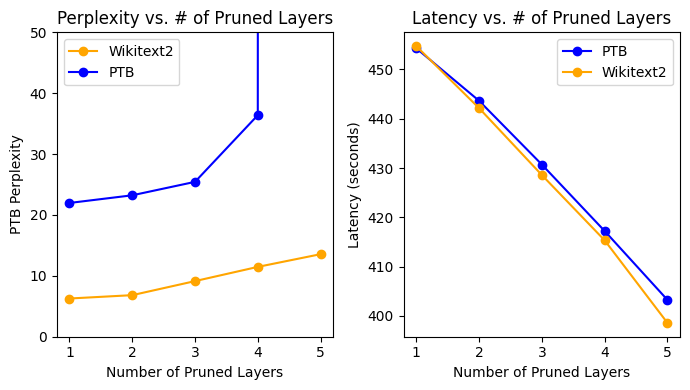

In [8]:
# PTB 데이터셋 결과
num_pruned_layers_ptb = [r[0] for r in results_clp]
sparsities_ptb = [r[1] for r in results_clp]
ppls_ptb = [r[2] for r in results_clp]
latencies_ptb = [r[3] for r in results_clp]

# Wikitext2 데이터셋 결과
num_pruned_layers_wikitext = [r[0] for r in results_clw]
sparsities_wikitext = [r[1] for r in results_clw]
ppls_wikitext = [r[2] for r in results_clw]
latencies_wikitext = [r[3] for r in results_clw]

plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(num_pruned_layers_wikitext, ppls_wikitext, marker='o', label="Wikitext2", color='orange')
plt.plot(num_pruned_layers_ptb, ppls_ptb, marker='o', label="PTB", color='b')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("PTB Perplexity")
plt.ylim(0, 50)
plt.title("Perplexity vs. # of Pruned Layers")
plt.legend()

# Latency
plt.subplot(1, 2, 2)
plt.plot(num_pruned_layers_ptb, latencies_ptb, marker='o', label="PTB", color='b')
plt.plot(num_pruned_layers_wikitext, latencies_wikitext, marker='o', label="Wikitext2", color='orange')
plt.xlabel("Number of Pruned Layers")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. # of Pruned Layers")
plt.legend()

plt.tight_layout()
plt.show()
